In [1]:
import pytraj as pt
from sklearn.cluster import KMeans
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DIR = '/hdd/si_han/GPU0/si_han/Project/Abeta/'
TRAJ='/hdd/si_han/GPU0/si_han/Project/Abeta/1us_IDPS.dcd'
TOP='/hdd/si_han/GPU0/si_han/Project/Abeta/idps_1.prmtop'

### Load Trajectory

In [3]:
traj = pt.iterload(TRAJ,TOP)
frameidx=np.array(range(traj.n_frames))
traj

pytraj.TrajectoryIterator, 10000 frames: 
Size: 0.140145 (GB)
<Topology: 627 atoms, 42 residues, 1 mols, non-PBC>
           

#### superimpose the trajectory to the refertence frame

In [4]:
pt.superpose(traj, ref=0, mask='@CA')

pytraj.TrajectoryIterator, 10000 frames: 
Size: 0.140145 (GB)
<Topology: 627 atoms, 42 residues, 1 mols, non-PBC>
           

### Cluster by Dihedral Angles

#### Compute phi and psi from the trajectory (this will take a while)

In [5]:
PhiPsi=[]
for i in range(1,traj.top.n_residues):
    tmp = pt.dihedral(traj['(:%d,%d)&(@CA,C,N)'%(i,i+1)],[[0,1,2,3],[2,3,4,5]]).T
    PhiPsi.append(tmp)
PhiPsi = np.concatenate(PhiPsi,axis=1)

In [6]:
PhiPsi.shape

(10000, 82)

#### for each dihedral, compute sin($\theta$) and cos($\theta$)

In [7]:
data = PhiPsi[:].copy()
data = np.concatenate([np.sin(data/360*2*np.pi),np.cos(data/360*2*np.pi)],axis=1)
data.shape

(10000, 164)

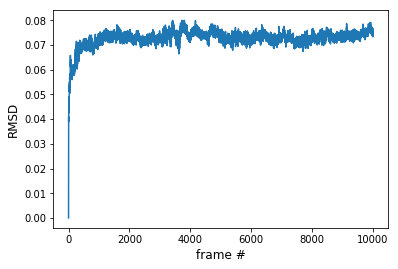

In [8]:
RMSD_data = np.linalg.norm(data - data[0,:], axis=1)/data.shape[1]

plt.figure()
plt.plot(range(len(RMSD_data)), RMSD_data)
plt.xlabel('frame #', fontsize = 12)
plt.ylabel('RMSD', fontsize = 12)
plt.show()

#### Optimize k using an elbow curve

In [13]:
Kdistant=[]
n_datas = len(RMSD_data)
for k in range(1,20):
    tmp=0
    kmeans = KMeans(n_clusters=k, init='k-means++').fit(RMSD_data.reshape(-1,1))
    labels = kmeans.predict(RMSD_data.reshape(-1,1))
    C = kmeans.cluster_centers_
    

    tmp+=np.linalg.norm(RMSD_data.reshape(-1,1)[labels==(k-1)] - C[(k-1)], axis=1).sum()
    Kdistant.append([k,tmp/n_datas])
Kdistant=np.array(Kdistant)

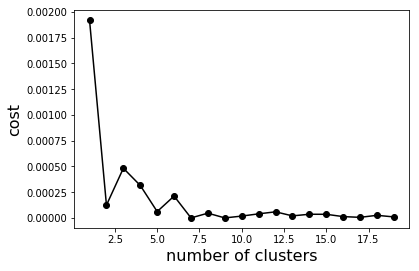

In [14]:
plt.figure()
plt.plot(Kdistant[:,0],Kdistant[:,1], marker='o', color='k')
plt.xlabel('number of clusters', fontsize=16)
plt.ylabel('cost', fontsize=16)
plt.show()

In [15]:
nc=7 # change the optimized number of clusters here according to the elbow curve
kmeans = KMeans(n_clusters=nc, init='k-means++').fit(data)
labels = kmeans.predict(data)
C = kmeans.cluster_centers_

#### Color each cluster

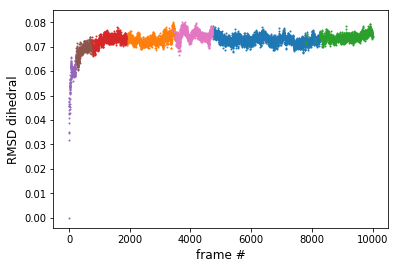

In [16]:
RMSD_data = np.linalg.norm(data - data[0,:], axis=1)/data.shape[1]

plt.figure()
for i in range(len(C)):
    plt.scatter(np.array(range(len(RMSD_data)))[labels==i], RMSD_data[labels==i], s=1)
plt.xlabel('frame #', fontsize = 12)
plt.ylabel('RMSD dihedral', fontsize = 12)
plt.show()

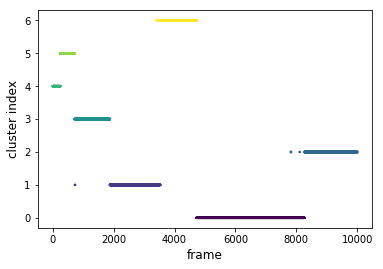

In [17]:
plt.figure()
plt.scatter(range(len(data)), labels, c= labels, s = 2)
plt.xlabel('frame', fontsize = 12)
plt.ylabel('cluster index', fontsize = 12)
plt.show()

#### Export separate trajectories of clusters

In [18]:
Out = DIR+'/'+'RMSD_dihedral' # make sure you've created this ooutput folder in your computer

In [19]:
for i in range(nc):
    traj[frameidx[labels==i].tolist()].save(Out+'/rmsd_dihedral_%d.dcd'%(i+1), overwrite=True)
    print("cluster %d"%(i+1), "%d frames"%len(frameidx[labels==i]))

cluster 1 3535 frames
cluster 2 1648 frames
cluster 3 1739 frames
cluster 4 1158 frames
cluster 5 245 frames
cluster 6 473 frames
cluster 7 1202 frames
